In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter

import sys
np.set_printoptions(threshold=sys.maxsize)

disp_figs = True

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [572]:
M = 2 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 6 # hz
background_noise_fr = 5 # h

np.random.seed(41)

In [573]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

In [574]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 100 colors (10 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])


# Generate the PG Kernels


In [575]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

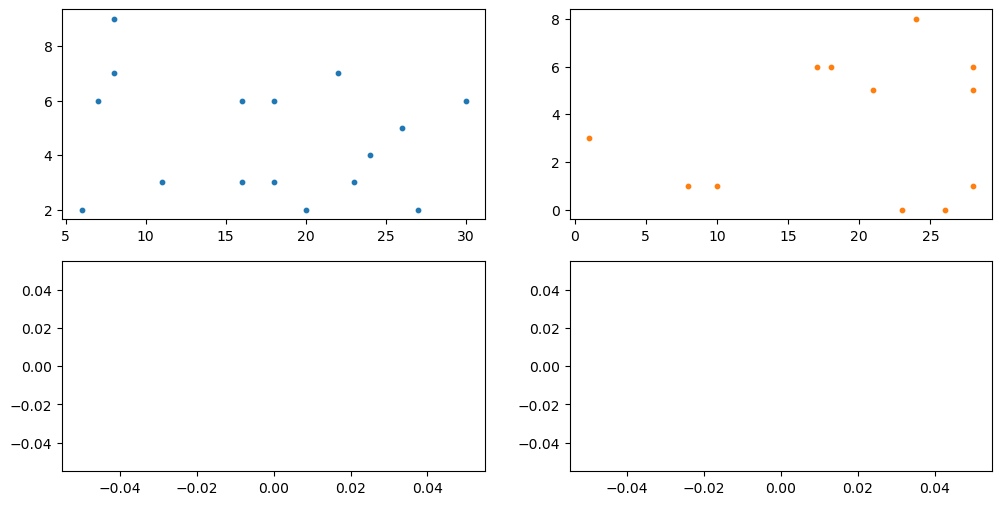

In [576]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i+1], K_sparse[0][K_sparse[2]==i+1],c=palette[i+1],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences


In [577]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

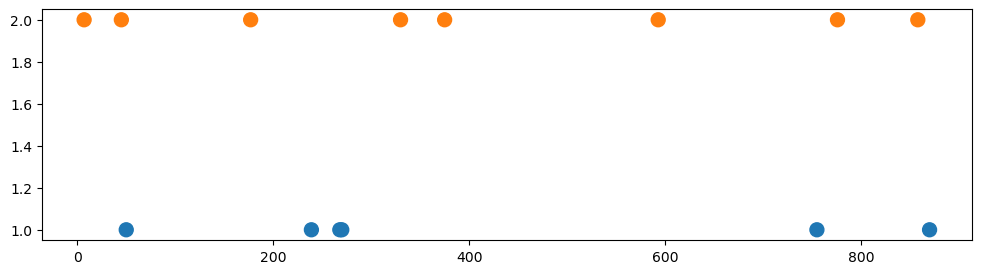

In [578]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=palette[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [579]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.randint(0,999,(N,T+D))
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
debug = A_dense
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

In [580]:
B_sparse

(array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([ 50, 239, 268, 270, 755, 870,   7,  45, 177, 330, 375, 593, 776,
        858], dtype=int64))

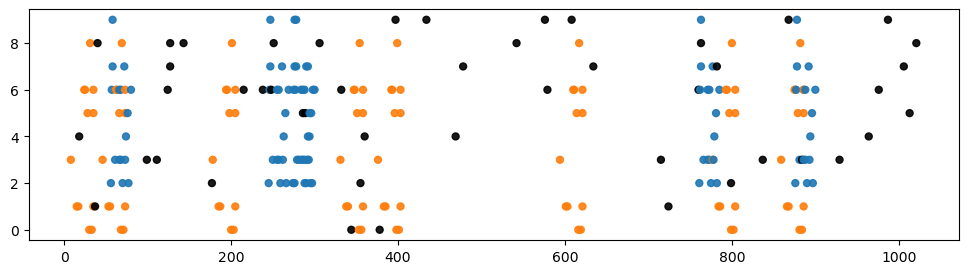

In [581]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

[[<matplotlib.lines.Line2D at 0x1b56af34690>],

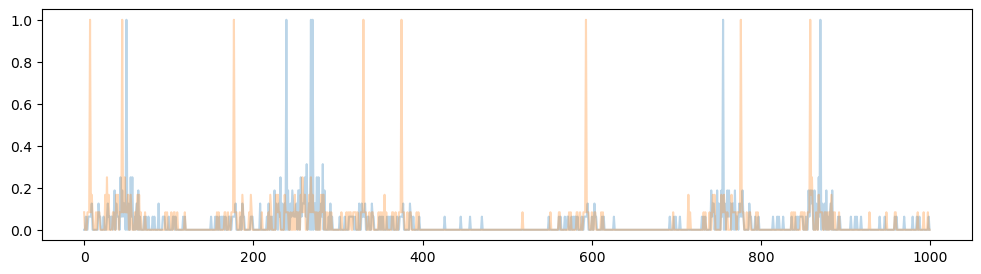

In [652]:
# Take a ground truth pattern from K_dense and convolute it with A_dense to make sure that perfect knowledge can pull out
# the timings of the pattern

test = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 0
[plt.plot(test[:,i],color=palette[i+1],alpha=0.3) for i in range(M)]

# looks good

In [651]:
test.shape

(1000, 2)

# Windowing the data

In [583]:
test_row = 0

In [584]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

In [585]:
A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy(),A_sparse[2][valid_spikes].copy())

In [586]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
#     windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 231, neurons: 10, depth: 32


In [587]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [588]:
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    test = windows[N_labels==n]
    if len(test) > 0:
        x = np.zeros((len(test),len(test)))
        for i in range(test.shape[0]):
            for j in range(test.shape[0]):
                x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
        sim_mats.append(x)
        dissimilarity = 1 - x
        HDPs.append(linkage(dissimilarity, method='complete'))
        clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

clusters= np.array(clusters)

C:\Users\miles\AppData\Local\Temp\ipykernel_12016\3910738687.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_12016\3910738687.py:18: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


In [589]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
    if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]
        

In [590]:
''' 
This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 


with some help from chatgpt
'''

from collections import Counter

# Convert the list of lists to a set of tuples to remove duplicates
unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

# Convert the set of tuples back to a list of lists
unique_sublists = [list(sublist) for sublist in unique_sublists_set]

# Count the occurrences of each unique sublist in the original list
sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

# Print the unique sublists and their respective counts
for sublist in unique_sublists:
    count = sublist_counts[tuple(sublist)]
    print(f"{sublist}: {count} occurrences")

sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron


[189, 31, 485, 115]: 2 occurrences
[189, 516, 115]: 2 occurrences
[636]: 1 occurrences
[92]: 1 occurrences
[0]: 1 occurrences
[218, 2, 485, 115]: 1 occurrences
[163]: 1 occurrences
[189, 29, 487]: 1 occurrences
[132, 153, 45, 218, 183, 82]: 1 occurrences
[38, 132, 153, 45, 218, 183, 82]: 7 occurrences
[189, 29, 2, 485, 115]: 9 occurrences
[218, 2, 175, 310, 115]: 1 occurrences
[701]: 1 occurrences
[153, 45, 218, 265]: 1 occurrences
[170, 153, 45, 218, 183, 82]: 1 occurrences
[38, 132, 153, 45, 218, 183]: 2 occurrences


In [591]:
''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(A_trunc[1])
sorted_x = A_trunc[1][sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)


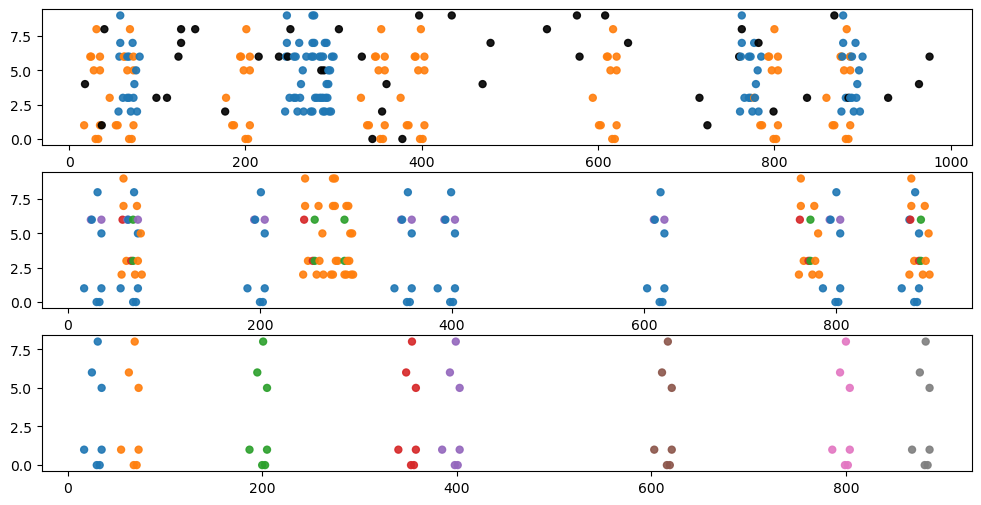

In [592]:
%matplotlib inline
sort_criteria_1 = recovered_labels 
sort_criteria_2 = all_labels[0]
fig,ax = plt.subplot_mosaic('A;B;C',figsize=(12,6))
ax['A'].scatter(A_trunc[1],A_trunc[0],c=palette[A_trunc[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_trunc[1][sort_criteria_1!=0],A_trunc[0][sort_criteria_1!=0],c=palette[sort_criteria_1[sort_criteria_1!=0]],alpha=0.9,s=100,marker='.')
ax['C'].scatter(A_trunc[1][sort_criteria_2!=0],A_trunc[0][sort_criteria_2!=0],c=palette[sort_criteria_2[sort_criteria_2!=0]],alpha=0.9,s=100,marker='.')
plt.show()

In [597]:
recovered_labels.shape, A_trunc[2].shape

((231,), (231,))

In [600]:
recovered_labels, A_trunc[2]

(array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2,
        2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2,
        4, 3, 2, 0, 0, 0, 2, 4, 3, 2, 2, 2, 0, 0, 3, 2, 2, 0, 0, 0, 0, 2,
        4, 3, 0, 2, 0, 0, 2, 0, 4, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0,
        1, 2, 5, 1, 5, 4, 5, 1, 0, 3, 5, 0, 0, 5, 1, 5, 0, 0, 4, 0, 0, 3,
        0, 0, 0, 0, 0, 3, 0, 0, 0, 5, 1, 5, 5, 1, 5, 0, 5, 1, 5, 0, 4, 0,
        3, 0, 5, 1, 5, 0, 1, 4, 0, 0, 3, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        0, 0, 2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2]),
 array([2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2

In [601]:
unique_labels_1, unique_labels_2

(array([0, 1, 2, 3, 4, 5]), array([0, 1, 2], dtype=int64))

In [636]:
import numpy as np
from scipy.optimize import linear_sum_assignment

labels_array_1 = recovered_labels
labels_array_2 = A_trunc[2]

# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Create a dictionary to store the many-to-one mapping
mapping_dict = {}

# Populate the mapping dictionary with the optimal mapping
for i, j in zip(row_indices, col_indices):
    label_1 = unique_labels_1[i]
    label_2 = unique_labels_2[j]
    
    if label_1 in mapping_dict:
        mapping_dict[label_1].append(label_2)
    else:
        mapping_dict[label_1] = [label_2]

# Find unmatched labels from labels_array_1
unmatched_labels_1 = np.setdiff1d(unique_labels_1, list(mapping_dict.keys()))

# Handle unmatched labels by assigning them to the closest label in labels_array_2
for label_1 in unmatched_labels_1:
    closest_label_2 = unique_labels_2[np.argmin(cost_matrix[label_1, :])]
    mapping_dict[label_1] = [closest_label_2]

# Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
# Use the get method with a default value of -1 for labels without a mapping
mapped_labels = np.array([mapping_dict[label] for label in labels_array_1]).squeeze()



In [637]:
unmatched_labels_1

array([3, 4, 5])

In [638]:
mapping_dict

{0: [0], 1: [2], 2: [1], 3: [1], 4: [1], 5: [2]}

In [639]:
cost_matrix

array([[-43., -22., -24.],
       [  0.,   0., -56.],
       [  0., -54.,   0.],
       [  0., -10.,   0.],
       [  0.,  -8.,   0.],
       [  0.,   0., -14.]])

In [640]:
mapped_labels.shape, recovered_labels.shape

((231,), (231,))

In [645]:
mapped_lab

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 1, 0, 2, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0,
       2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 0,
       1, 0, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

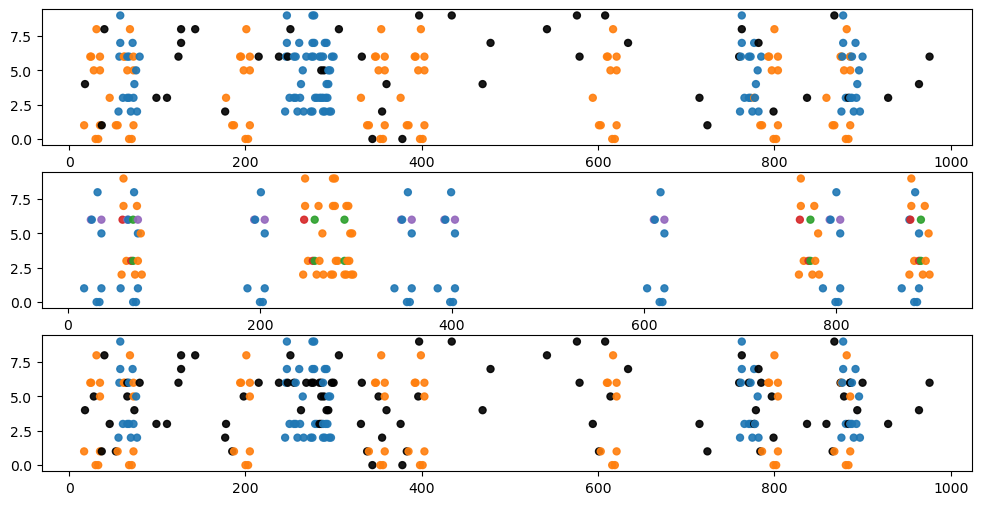

In [647]:
%matplotlib inline
sort_criteria_1 = recovered_labels 
sort_criteria_2 = mapped_labels
fig,ax = plt.subplot_mosaic('A;B;C',figsize=(12,6))
ax['A'].scatter(A_trunc[1],A_trunc[0],c=palette[A_trunc[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_trunc[1][sort_criteria_1!=0],A_trunc[0][sort_criteria_1!=0],c=palette[sort_criteria_1[sort_criteria_1!=0]],alpha=0.9,s=100,marker='.')
ax['C'].scatter(A_trunc[1],A_trunc[0],c=palette[sort_criteria_2],alpha=0.9,s=100,marker='.')
plt.show()

In [593]:
B_sparse, all_times

((array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
  array([ 50, 239, 268, 270, 755, 870,   7,  45, 177, 330, 375, 593, 776,
         858], dtype=int64)),
 [array([ 17,  55, 187, 340, 385, 603, 786, 868], dtype=int64),
  array([ 56, 245, 274, 276, 761, 876], dtype=int64),
  array([ 68, 257, 288, 773, 888], dtype=int64),
  array([ 57, 246, 762, 877], dtype=int64),
  array([ 24,  62, 194, 347, 392, 610, 793], dtype=int64)])

In [594]:
TP = 0
TN = 0
total_TP = 0
total_TN = 0
for m in range(M):
    TP += np.sum(((A_trunc[2]==m) & (mapped_labels==m)) == True)
    TN += np.sum(((A_trunc[2]!=m) & (mapped_labels!=m)) == True)
    total_TP += np.sum(A_trunc[2]==m)
    total_TN += np.sum(A_trunc[2]!=m)
    
TP/total_TP, TN/total_TN, total_TP,total_TN

NameError: name 'mapped_labels' is not defined

In [154]:
accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])
accuracy

C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3825156868.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])


0.0